## Homework - California Housing Prices

In this homework, we will create a linear regression model that predicts the median price of houses in California.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


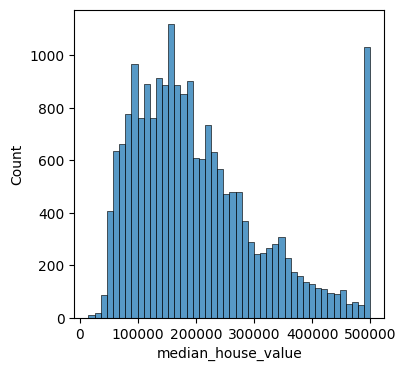

In [3]:
plt.figure(figsize=(4,4))
sns.histplot(df['median_house_value'], kde=False);

The distribution is skewed to the right, but does not have a long tail.

For this homework, we are going to use the following features:

In [4]:
features = ['latitude',
            'longitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
            'median_house_value']

df = df[features]

##### Question 1
Find a feature with missing values. How many missing values does it have?

In [5]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

Total bedrooms features have 207 missing values. 

##### Question 2
What's the median (50% percentile) for variable 'population'?

In [6]:
df['population'].median()

1166.0

Split the data
- Shuffle the initial dataset, use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Make sure that the target value ('median_house_value') is not in your dataframe.
- Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [7]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

np.random.seed(42) 
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

df_train.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
20046,36.06,-119.01,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0
3024,35.14,-119.46,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0
15663,37.80,-122.44,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0
20484,34.28,-118.72,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0
9814,36.62,-121.93,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0


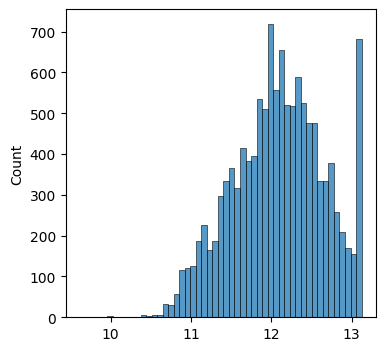

In [8]:
# Creating target dataframes and applying log1p to all
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

# Removing median_house_value feature from the features' dataframe
df_train.drop(['median_house_value'], axis=1, inplace=True)
df_val.drop(['median_house_value'], axis=1, inplace=True)
df_test.drop(['median_house_value'], axis=1, inplace=True)

# Plotting the target values after transformation
plt.figure(figsize=(4,4))
sns.histplot(y_train, kde=False);

It is clear that the data is more normally distributed after the transformation.

##### Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good

First, let's create the functions that implement the linear regression and calculate the RMSE.

In [9]:
def linear_regression(X:np.array, y:np.array)->tuple:
    """Performs linear regression algorithm. 

    Args:
        X (np.array): features.
        y (np.array): results.

    Returns:
        tuple: A tuple containing the bias w_0 and the weights w_n.
    """

    # adding the dummy column for the bias term w0
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T@X
    XTX_inv = np.linalg.inv(XTX)

    w = XTX_inv@X.T@y
    
    return w[0], w[1:]


def rmse(y_true:np.array, y_pred:np.array)->float:
    """Calculates the rmse for two arrays.

    Args:
        y_true (np.array): true values
        y_pred (np.array): predicted values

    Returns:
        float: RMSE value.
    """

    error = y_true - y_pred
    mse = (error ** 2).mean()

    return np.sqrt(mse)

Now, we will train two models using both approaches.

In [10]:
# Creating training arrays and filling missing values
X_train_zero = df_train.fillna(0).values
X_train_mean = df_train.fillna(df_train['total_bedrooms'].mean()).values

# Creating validation arrays and filling missing values
X_val_zero = df_val.fillna(0).values
X_val_mean = df_val.fillna(df_train['total_bedrooms'].mean()).values # Should be imputed with train mean

# Training models
w0_zero, w_zero = linear_regression(X_train_zero, y_train)
w0_mean, w_mean = linear_regression(X_train_mean, y_train)

# Creating predictions
y_pred_zero = w0_zero + X_train_zero@w_zero
y_pred_mean = w0_mean + X_train_mean@w_mean
y_pred_val_zero = w0_zero + X_val_zero@w_zero
y_pred_val_mean = w0_mean + X_val_mean@w_mean

# Scoring the models
score_zero = rmse(y_train, y_pred_zero)
score_mean = rmse(y_train, y_pred_mean)
score_val_zero = rmse(y_val, y_pred_val_zero)
score_val_mean = rmse(y_val, y_pred_val_mean)

print("Train score for imputing with 0:", np.round(score_zero, 2))
print("Train score for imputing with mean:", np.round(score_mean, 2))
print("Validation score for imputing with 0:", np.round(score_val_zero, 2))
print("Validation score for imputing with mean:", np.round(score_val_mean, 2))

Train score for imputing with 0: 0.34
Train score for imputing with mean: 0.34
Validation score for imputing with 0: 0.33
Validation score for imputing with mean: 0.33


Both approaches are equally good.

##### Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

If there are multiple options, select the smallest r.

First, we need to create the linear regression function with regularization:

In [11]:
def linear_regression_reg(X:np.array, y:np.array, reg:float=0.0)->tuple:
    """Performs linear regression algorithm. 

    Args:
        X (np.array): features.
        y (np.array): results.
        reg (float, optional): Regularization parameter. Defaults to 0.0.

    Returns:
        tuple: A tuple containing the bias w_0 and the weights w_n.
    """

    # adding the dummy column for the bias term w0
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T@X
    XTX = XTX - np.eye(XTX.shape[0])*reg
    XTX_inv = np.linalg.inv(XTX)

    w = XTX_inv@X.T@y
    
    return w[0], w[1:]

Now we can train the models using different regularization values:

In [12]:
X_train = df_train.fillna(0).values # Create the train set
X_val = df_val.fillna(0).values # Create the validation set

print("Validation RMSE:")
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = linear_regression_reg(X_train, y_train, reg=r) # fit the model to the data

    y_pred_val = w_0 + X_val@w

    score = round(rmse(y_val, y_pred_val), 2)
    print("{}: {}".format(r, score))

Validation RMSE:
0: 0.33
1e-06: 0.33
0.0001: 0.33
0.001: 0.33
0.01: 0.33
0.1: 0.33
1: 0.47
5: 0.35
10: 0.34


The r values in the interval from 0 to 0.1 give the same RMSE, so we choose the smallest value, r = 0. 

##### Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [13]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

scores = []
for seed in seed_values:
    # Setting seeds and shuffling data
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    np.random.seed(seed) 
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]

    # Creating features' dataframes
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    # Creating targets' dataframes and applying log1p to all
    y_train = np.log1p(df_train['median_house_value'].values)
    y_val = np.log1p(df_val['median_house_value'].values)
    y_test = np.log1p(df_test['median_house_value'].values)

    # Removing median_house_value feature from the features' dataframe
    df_train.drop(['median_house_value'], axis=1, inplace=True)
    df_val.drop(['median_house_value'], axis=1, inplace=True)
    df_test.drop(['median_house_value'], axis=1, inplace=True)

    X_train = df_train.fillna(0).values # Create the train set
    X_val = df_val.fillna(0).values # Create the validation set

    w_0, w = linear_regression(X_train, y_train) # fit the model to the data (without regularization)

    y_pred_val = w_0 + X_val@w    

    score = np.round(rmse(y_val, y_pred_val), 2)
    scores.append(score)

    print("{}: {}".format(seed, score))

print('Mean =', round(np.mean(scores), 2))
print('Standard deviation =', round(np.std(scores), 3))

0: 0.34
1: 0.34
2: 0.33
3: 0.34
4: 0.34
5: 0.34
6: 0.35
7: 0.34
8: 0.35
9: 0.34
Mean = 0.34
Standard deviation = 0.005


##### Question 6
Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?

In [16]:
# Setting seeds and shuffling data
n = len(df)
n_test = int(0.2 * n)
n_train = n - n_test
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

# Creating features' dataframes
df_train = df_shuffled.iloc[:n_train].copy()
df_test = df_shuffled.iloc[n_train:].copy()

# Creating targets' dataframes and applying log1p to all
y_train = np.log1p(df_train['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

# Removing median_house_value feature from the features' dataframe
df_train.drop(['median_house_value'], axis=1, inplace=True)
df_test.drop(['median_house_value'], axis=1, inplace=True)

X_train = df_train.fillna(0).values # Create the train set
X_test = df_test.fillna(0).values # Create the test set

w_0, w = linear_regression_reg(X_train, y_train, reg=0.001) # fit the model to the data (without regularization)

y_pred_train = w_0 + X_train@w
y_pred_test = w_0 + X_test@w    

score_train = np.round(rmse(y_train, y_pred_train), 2)
score_test = np.round(rmse(y_test, y_pred_test), 2)

print("Train RMSE:", score_train)
print("Test RMSE:", score_test)

Train RMSE: 0.34
Test RMSE: 0.35
